In [25]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.style.use("fivethirtyeight")
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams['figure.figsize'] = (10, 5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# load data
df = pd.read_pickle("/content/drive/MyDrive/1.Mestrado/2. Disertação/6. vary_model/hs_vary/data_omega.pkl")
#df = df[df.G.isin([0, .25])]
df_row = df.copy()

In [27]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res


df = explode(df, ["xt", "yt", "t", "xt_dot"])

In [28]:
df

,G,c,hs,k,k1,m,xt,yt,t,xt_dot
0,0,0.106495,3.5,1.134111,0,1,0.000000,-0.635917,0.0,0.000000
1,0,0.106495,3.5,1.134111,0,1,-0.002063,0.027279,0.1,-0.030124
2,0,0.106495,3.5,1.134111,0,1,-0.006266,-0.790882,0.2,-0.067419
3,0,0.106495,3.5,1.134111,0,1,-0.018710,-1.903345,0.3,-0.199514
4,0,0.106495,3.5,1.134111,0,1,-0.046249,-0.918136,0.4,-0.334099
...,...,...,...,...,...,...,...,...,...,...
107995,0,0.106495,3.5,1.134111,0,1,0.275070,-1.764525,10799.5,-0.710682
107996,0,0.106495,3.5,1.134111,0,1,0.195931,-0.709368,10799.6,-0.852792
107997,0,0.106495,3.5,1.134111,0,1,0.107687,-0.072154,10799.7,-0.899731
107998,0,0.106495,3.5,1.134111,0,1,0.016913,-0.360873,10799.8,-0.918799


In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class SmartDynamicPredictor:
    def __init__(self, 
                 data: pd.DataFrame, 
                 train_ratio: float,
                 transient2cut: float,
                 scaler: callable,
                 val_split: float = .1
                 ):
        """ Class that do the treatment of the dataset for prediction 
            in the model
            Args:
                data (Dataframe): Data frame of the results
                train_ration (float): Ratio that will be used for train de model
                transient2curt (float): Part of the data that will be ignored
                scaler (callable): Scaler function to call and scale
                val_split (float): Validation split data
        """
        self.data = data
        self.train_ratio = train_ratio
        self.transient2cut = transient2cut
        # Data without transient
        self.df = self.data[self.data.t > self.transient2cut]
        # Dataframe to train
        ttrain = self.df.t.max() * self.train_ratio
        self.df2train = self.df[self.df.t < ttrain]
        # Test data
        mask_test = (self.df.t > ttrain) & (self.df.t <= self.df.t.max())
        self.df2test = self.df[mask_test]
        # Scaler
        self._scaler = scaler
        self.dt = np.diff(self.df.t)[0]
        # values
        self.g_values = list(self.df.G.values)
        self.val_split = val_split

    def get_scaler(self):
        return self._scaler

    def scale_col(self, 
                  serie: pd.Series,
                  scaler=None):
        """ Scale a vector and return the scaler """
        vector = serie.values.reshape(-1, 1)
        if scaler:
            scld_data = scaler.fit_transform(vector)
            return scld_data.reshape(scld_data.shape[0])
        local_scl = self.get_scaler()
        local_scl = local_scl()
        scld_data = local_scl.fit_transform(vector)
        return scld_data.reshape(scld_data.shape[0]), local_scl

    def scld_data2train(self, 
                        df: pd.DataFrame,
                        cols2scl: list,
                        ):
        """ Routine to scale dataframe """
        d = df.copy()
        #d = d[d.G == g_value]
        # Scales fitted
        scalers = {}
        for col in cols2scl:
            serie = d[col]
            scld_data, scaler = self.scale_col(serie)
            d[col] = scld_data
            scalers[col] = scaler
        return d, scalers

    def scld_test(self, 
                  df: pd.DataFrame,
                  scalers: dict,
                  ):
        """ Appy scaled on the test dataframe """
        d = df.copy()
        #d = d[d.G == g]
        for col in scalers:
            scaler = scalers[col]
            d[col] = self.scale_col(serie=d[col],
                                    scaler=scaler)
        return d

    def data_prep(self,
                  df: pd.DataFrame,
                  input_cols: list,
                  output_col: str):
        """ Prepare data for feed keras model """
        d = df.copy()
        inputs = {}
        c = 0
        vals = []
        for i, v in enumerate(input_cols):
            vals.append(d[v].values)
        vals.append(d[output_col].values)

        to_stack = []
        n = df.shape[0]
        for vec in vals:
            to_stack.append(vec.reshape(n, 1))
        to_stack = tuple(to_stack)
        return np.hstack(to_stack)

    def split_sequences(self, sequences, t_window):
        """ Split data to train the neural net model """
        n_steps = int(t_window / self.dt)
        X, y = list(), list()
        for i in range(len(sequences)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the dataset
            if end_ix > len(sequences):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    def agg_data_prep(self,
                      df: pd.DataFrame,
                      input_cols: list,
                      output_col: str,
                      t_window: float):
        """ Aggregate data_reparation """
        dataset = self.data_prep(df, input_cols, output_col)
        x, y = self.split_sequences(dataset, t_window)
        return x, y

    def main(self,
             input_cols: list,
             output_col: str,
             t_window: float,
             hs_values: list):
        """ Main function """
        cols2fit = input_cols + [output_col]

        aux_train = pd.DataFrame()
        aux_test = pd.DataFrame()
        self.scalers = {}
        df2tr, self.scalers = self.scld_data2train(self.df2train,
                                                   cols2fit,
                                                          )
        df2te = self.scld_test(self.df2test,
                               self.scalers,
)
        """
        for g in g_values:
            df2tr, self.scalers[g] = self.scld_data2train(self.df2train,
                                                          cols2fit,
                                                          )
            df2te = self.scld_test(self.df2test,
                                   self.scalers[g],
                                   )
            aux_train = pd.concat([aux_train, df2tr])
            aux_test = pd.concat([aux_test, df2te])
        """
        self.df2train = df2tr
        self.df2test = df2te
        
        x_train_aux = []
        x_test_aux = []
        x_val_aux = []
        y_train_aux = []
        y_test_aux = []
        y_val_aux = []
        all_data_by_hs = {}
        for hs in hs_values:
            
            df2tr = self.df2train[self.df2train.hs==hs]
            df2te = self.df2test[self.df2test.hs==hs]
            idx_val = int(df2te.shape[0] * self.val_split)
            x, y = self.agg_data_prep(df2tr, 
                                      input_cols, 
                                      output_col,
                                      t_window)
            x_train_aux.append(x)
            y_train_aux.append(y)
            # test
            x, y = self.agg_data_prep(df2te.iloc[idx_val:], 
                                      input_cols, 
                                      output_col,
                                      t_window)
            x_test_aux.append(x)
            y_test_aux.append(y)
            # validation
            x, y = self.agg_data_prep(df2te.iloc[:idx_val], 
                                      input_cols, 
                                      output_col,
                                      t_window)
            x_val_aux.append(x)
            y_val_aux.append(y)

            #all data
            df = pd.concat([df2tr, df2te])
            x, y = self.agg_data_prep(df, 
                                      input_cols, 
                                      output_col,
                                      t_window)
            all_data_by_hs[hs] = {"x": x,
                                "y": y}


        x_train_aux = tuple(x_train_aux)
        x_test_aux = tuple(x_test_aux)
        x_val_aux = tuple(x_val_aux)
        y_train_aux = tuple(y_train_aux)
        y_test_aux = tuple(y_test_aux)
        y_val_aux = tuple(y_val_aux)
        
        # storege_data
        data = {}
        data["x_train"] = np.vstack(x_train_aux)
        data["x_test"] = np.vstack(x_test_aux)
        data["x_val"] = np.vstack(x_val_aux)
        data["y_train"] = np.hstack(y_train_aux)
        data["y_test"] = np.hstack(y_test_aux)
        data["y_val"] = np.hstack(y_val_aux)
        data["n_steps"] = n_steps = int(t_window / self.dt)
        data["hs_values"] = hs_values
        data["x_train_aux"] = x_train_aux
        data["x_test_aux"] = x_test_aux
        data["x_val_aux"] = x_val_aux
        data["y_train_aux"] = y_train_aux
        data["y_test_aux"] = y_test_aux
        data["y_val_aux"] = y_val_aux
        data["all_data"] = all_data_by_hs

        return data


In [30]:
# train ratio
TRAIN_RATIO = .5
# Cut transient part
T2CUT = 100
SCALER = StandardScaler
T_WINDOW = 200
VAL_SPLIT = .1

obj = SmartDynamicPredictor(data=df, 
                            train_ratio=TRAIN_RATIO, 
                            transient2cut=T2CUT,
                            scaler=SCALER,
                            val_split=VAL_SPLIT
                            )
data = obj.main(input_cols=["yt"], 
                output_col="xt", 
                t_window=T_WINDOW,
                hs_values=df.hs.unique())


In [31]:
n_steps = data["n_steps"]
x_train = data["x_train"]
y_train = data["y_train"]
y_test = data["y_test"]
x_test = data["x_test"]
x_val = data["x_val"]
y_val = data["y_val"]
all_data = data["all_data"]
n_features = x_train.shape[2]


In [32]:
# Concatenar os resultados de hs com essa rede atual 
# Estruturar a rede final. Como ????


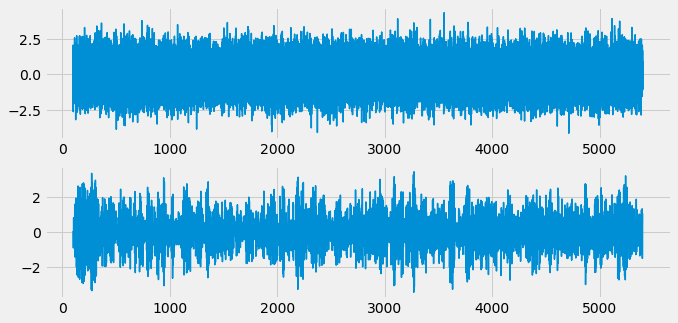

In [33]:
def plot_time_series(hs, ax1, ax2):
    data_train = obj.df2train[obj.df2train.hs == hs]
    data_test = obj.df2test[obj.df2test.hs == hs]
    #data_val = obj.df2val[obj.df2val.G == g]

    
    ax1.plot(data_train.t, data_train.yt)
    ax2.plot(data_train.t, data_train.xt)
    
fig, (ax1, ax2) = plt.subplots(2, 1)
for hs in df.hs.unique():
    plot_time_series(hs, ax1, ax2)

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow import keras
import tensorflow as tf


optimizer = keras.optimizers.Adam(learning_rate=0.0001)

# definir modelo
model = Sequential()
model.add(Conv1D(filters=25, 
                 kernel_size=2, 
                 activation="relu", 
                 input_shape=(n_steps, n_features)))
model.add(Conv1D(filters=25, 
                 kernel_size=2, 
                 activation="relu", 
                 input_shape=(n_steps, n_features)))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss="mse")

In [35]:
#model = keras.models.load_model()("/content/drive/MyDrive/1.Mestrado/2. Disertação/6. vary_model/hs_vary/keras_model")

In [ ]:
# fit model
history = model.fit(x_train, 
                    y_train, 
                    epochs=300, 
                    verbose='auto', 
                    validation_split=0, 
                    validation_data=(x_val, y_val),
                    batch_size=64,
                    shuffle=False)


Epoch 1/300
797/797 [==============================] - 100s 125ms/step - loss: 0.3629 - val_loss: 0.6066
Epoch 2/300
570/797 [====================>.........] - ETA: 27s - loss: 0.1541

In [ ]:
model.save("/content/drive/MyDrive/1.Mestrado/2. Disertação/6. vary_model/hs_vary/keras_model")

In [ ]:
stoppp

In [ ]:
#model = keras.models.load_model("/content/drive/MyDrive/1.Mestrado/2. Disertação/6. vary_model/keras_model")

In [ ]:
from sklearn.metrics import r2_score
yhat = model.predict(x_train)
r2 = r2_score(obj.scalers["xt"].inverse_transform(yhat), 
              obj.scalers["xt"].inverse_transform(y_train))

print(f"Error R2: {round(r2, 3)}")

In [ ]:
r2_results = {}
yhat_results = {}
for idx, hs in enumerate(df.hs.unique()):
    x = all_data[hs]["x"]
    y = all_data[hs]["y"]
    yhat = list(model.predict(x))
    r2_results[hs] = r2_score(obj.scalers["xt"].inverse_transform(yhat), 
                             obj.scalers["xt"].inverse_transform(y))
    yhat_results[hs] = np.array(yhat) 

In [ ]:
df_row["r2_score"] = r2_results.values()
df_row["yhat"] = list(yhat_results.values())

In [ ]:
plt.plot(df_row.hs, 
         df_row.r2_score, 
         color="red"
         )
plt.ylabel("$r^2$")
plt.xlabel("Hs");

In [ ]:
import ipywidgets as widgets
hs_const = widgets.Dropdown(options=df.hs.unique(),
                           value=df.hs.unique()[0],
                           description="Hs: ")

def plot_func(hs):
    """ To plot timeseries """
    data1 = list(obj.df2train[obj.df2train.hs == hs].xt)
    data1 += list(obj.df2test[obj.df2test.hs == hs].xt)
    yhat = yhat_results[hs]
    plt.plot(data1[:], 
             color="blue", 
             zorder=1)
    plt.plot(yhat[:], 
             color="red", 
             zorder=2, 
             alpha=.5);
    plt.ylabel("x(t) [m]")
    #plt.xlabel("Time [s]")


In [ ]:
widgets.interactive(plot_func, hs=hs_const)